# GANs

This assignment consists of 4 parts, **to get full mark you should complete part 1 and any two of the three remaining parts**:
1. 1D data (obligatory)
2. SNGAN on CIFAR-10
3. BiGAN on MNIST
4. CycleGAN on ColoredMNIST

Each task is accompanied with some amount of code to allow you to concentrate on the most interesting parts of the assignment. You are free to modify any code in the solution section if you think it will make it more convenient. However you should not modify data acquisition and result sections.

Credit: this notebook is based on hw4 of "Deep Unsupervised Learning" by Berkeley

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import IPython
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from scipy.stats import norm
from tqdm import trange, tqdm_notebook
import os.path as osp
import warnings
warnings.filterwarnings('ignore')

# Question 1: Warmup

In this question, we will train 2 different variants of GANs on an easy 1D dataset. 

Execute the cell below to visualize our datasets.

In [0]:
def q1_data(n=20000):
    assert n % 2 == 0
    gaussian1 = np.random.normal(loc=-1, scale=0.25, size=(n//2,))
    gaussian2 = np.random.normal(loc=0.5, scale=0.5, size=(n//2,))
    data = (np.concatenate([gaussian1, gaussian2]) + 1).reshape([-1, 1])
    scaled_data = (data - np.min(data)) / (np.max(data) - np.min(data) + 1e-8)
    return 2 * scaled_data -1

def visualize_q1_dataset():
    data = q1_data()
    plt.hist(data, bins=50, alpha=0.7, label='train data')
    plt.legend()
    plt.show()

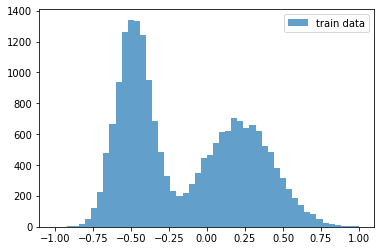

In [0]:
visualize_q1_dataset()

## Part 1(a)
In this part, we'll train our generator and discriminator via the original minimax GAN objective:
<insert GAN Objective here>
$$min_{G} max_{D} \mathbb{E}_{x \sim p_{data}} [\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$

Use an MLP for both your generator and your discriminator, and train until the generated distribution resembles the target distribution. 



### Solution

In [0]:
def train(generator, critic, c_loss_fn, g_loss_fn, train_loader, g_optimizer, c_optimizer, n_critic=1, g_scheduler=None, c_scheduler=None, weight_clipping=None):
    """
    generator: 
    critic: discriminator in 1ab, general model otherwise
    c_loss_fn: takes (generator, discriminator, real_batch)
    g_loss_fn: takes (generator, discriminator, real_batch)
    train_loader: instance of DataLoader class
    optimizer: 
    ncritic: how many critic gradient steps to do for every generator step
    """
    g_losses, c_losses = [], []
    generator.train()
    critic.train()
    for i, x in enumerate(train_loader):
        x = x.to(device).float()

        # discriminator/critic step
        # TODO

        if i % n_critic == 0:  # generator step
            # TODO
            if g_scheduler is not None:
                g_scheduler.step()
            if c_scheduler is not None:
                c_scheduler.step()
    return dict(g_losses=g_losses, c_losses=c_losses)

def train_epochs(generator, critic, g_loss_fn, c_loss_fn, train_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    if 'optim_cls' in train_args:
        g_optimizer = train_args['optim_cls'](generator.parameters(), lr=lr)
        c_optimizer = train_args['optim_cls'](critic.parameters(), lr=lr)
    else:
        g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0, 0.9))
        c_optimizer = optim.Adam(critic.parameters(), lr=lr, betas=(0, 0.9))
        
    if train_args.get('lr_schedule', None) is not None:
        g_scheduler = optim.lr_scheduler.LambdaLR(g_optimizer, train_args['lr_schedule'])
        c_scheduler = optim.lr_scheduler.LambdaLR(c_optimizer, train_args['lr_schedule'])
    else:
        g_scheduler = None
        c_scheduler = None 

    train_losses = dict()
    for epoch in tqdm_notebook(range(epochs), desc='Epoch', leave=False):
        generator.train()
        critic.train()
        train_loss = train(generator, critic, c_loss_fn, g_loss_fn, train_loader, 
                           g_optimizer, c_optimizer, n_critic=train_args.get('n_critic', 0), 
                           g_scheduler=g_scheduler, c_scheduler=c_scheduler,
                           weight_clipping=train_args.get('weight_clipping', None))
        
        for k in train_loss.keys():
            if k not in train_losses:
                train_losses[k] = []
            train_losses[k].extend(train_loss[k])

    if train_args.get('q1', False):  # q1, return the snapshots
        final_snapshot = get_training_snapshot(generator, critic)
        return [train_losses, *final_snapshot]
    else:
        return train_losses

def get_training_snapshot(generator, critic, n_samples=5000):
    generator.eval()
    critic.eval()
    xs = np.linspace(-1, 1, 1000)
    samples = generator.sample(n_samples).detach().cpu().numpy()
    critic_output = critic(torch.tensor(xs, device=device).float().unsqueeze(1)).detach().cpu().numpy()
    return samples, xs, critic_output

In [0]:
class MLP(nn.Module):
    def __init__(self, input_size, n_hidden, hidden_size, output_size):
        super().__init__()
        layers = []
        for _ in range(n_hidden):
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.LeakyReLU(0.2))
            input_size = hidden_size
        layers.append(nn.Linear(hidden_size, output_size))
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

class MLPGenerator(nn.Module):
    def __init__(self, latent_dim, n_hidden, hidden_size, data_dim):
        super().__init__()
        layers = []
        self.latent_dim = latent_dim
        self.mlp = MLP(latent_dim, n_hidden, hidden_size, data_dim)
    
    def forward(self, z):
        # TODO: outputs in [-1, 1]
        
    def sample(self, n):
        # n is the number of samples to return
        # TODO

class MLPDiscriminator(nn.Module):
    def __init__(self, latent_dim, n_hidden, hidden_size, data_dim):
        super().__init__()
        self.mlp = MLP(latent_dim, n_hidden, hidden_size, data_dim)
    
    def forward(self, z):
        # TODO: output probabilities in [0, 1]

In [0]:
device = 'cuda:0'
def q1_a(train_data):
    """
    train_data: An (20000, 1) numpy array of floats in [-1, 1]

    Returns
    - a (# of training iterations,) numpy array of discriminator losses evaluated every minibatch

    - a numpy array of size (5000,) of samples drawn from your model at the end of training
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid) 
        at each location in the previous array at the end of training
    """
  
    # create data loaders
    train_loader = data.DataLoader(train_data, batch_size=64, shuffle=True)

    # model
    g = MLPGenerator(1, 3, 128, 1).to(device)
    c = MLPDiscriminator(1, 3, 128, 1).to(device)

    # loss functions
    def g_loss(generator, critic, x):
        # TODO

    def c_loss(generator, critic, x):
        # TODO

    # train
    train_losses, samples, xs, ys = train_epochs(g, c, g_loss, c_loss, train_loader, dict(epochs=25, lr=1e-4, n_critic=2, q1=True))

    return train_losses['c_losses'], samples, xs, ys

### Results

In [0]:
def plot_gan_training(losses, title, fname):
    plt.figure()
    n_itr = len(losses)
    xs = np.arange(n_itr)

    plt.plot(xs, losses, label='loss')
    plt.legend()
    plt.title(title)
    plt.xlabel('Training Iteration')
    plt.ylabel('Loss')
    # savefig(fname)

def q1_gan_plot(data, samples, xs, ys, title, fname):
    plt.figure()
    plt.hist(samples, bins=50, density=True, alpha=0.7, label='fake')
    plt.hist(data, bins=50, density=True, alpha=0.7, label='real')

    plt.plot(xs, ys, label='discrim')
    plt.legend()
    plt.title(title)
    # savefig(fname)

def q1_save_results(part, fn):
    data = q1_data()
    losses, samples, xs, ys = fn(data)

    # loss plot
    plot_gan_training(losses, 'Q1{} Losses'.format(part), 'results/q1{}_losses.png'.format(part))

    # samples
    q1_gan_plot(data, samples, xs, ys, 'Q1{} Final'.format(part), 'results/q1{}_final.png'.format(part))

q1_save_results('a', q1_a)

## Part 1(b)
Here, we'll use the non-saturating formulation of the GAN objective. Now, we have two separate losses:
$$L^{(D)} = \mathbb{E}_{x \sim p_{data}} [\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$
$$L^{(G} = - \mathbb{E}_{z \sim p(z)} \log(D(G(z))$$

 ### Solution

In [0]:
def q1_b(train_data):
    # create data loaders
    train_loader = data.DataLoader(train_data, batch_size=64, shuffle=True)

    # model
    g = MLPGenerator(1, 3, 128, 1).to(device)
    c = MLPDiscriminator(1, 3, 128, 1).to(device)

    # loss functions
    def g_loss(generator, critic, x):
        # TODO

    def c_loss(generator, critic, x):
        # TODO

    # train
    train_losses, samples, xs, ys = train_epochs(g, c, g_loss, c_loss, train_loader, dict(epochs=25, lr=1e-4, n_critic=2, q1=True))

    return train_losses['c_losses'], samples, xs, ys

In [0]:
def q1_b(train_data):
  """
  train_data: An (20000, 1) numpy array of floats in [-1, 1]

  Returns
  - a (# of training iterations,) numpy array of discriminator losses evaluated every minibatch

  - a numpy array of size (5000,) of samples drawn from your model at the end of training
  - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
  - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid) 
      at each location in the previous array at the end of training
  """
  
  """ YOUR CODE HERE """

 ### Results

In [0]:
q1_save_results('b', q1_b)

# Question 2: GANs on CIFAR-10

In this exercise, you will train GANs on CIFAR-10. Execute the cell below to visualize the dataset. 

Files already downloaded and verified


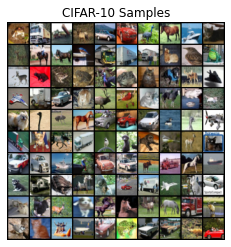

In [0]:
import torchvision
from torchvision.utils import make_grid

def show_samples(samples, fname=None, nrow=10, title='Samples'):
    samples = (torch.FloatTensor(samples) / 255).permute(0, 3, 1, 2)
    grid_img = make_grid(samples, nrow=nrow)
    plt.figure()
    plt.title(title)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')

    if fname is not None:
        savefig(fname)
    else:
        plt.show()

def load_q2_data():
    train_data = torchvision.datasets.CIFAR10("./data", transform=torchvision.transforms.ToTensor(),
                                              download=True, train=True)
    return train_data

def visualize_q2_data():
    train_data = load_q2_data()
    imgs = train_data.data[:100]
    show_samples(imgs, title=f'CIFAR-10 Samples')

visualize_q2_data()

 We'll use the CIFAR-10 architecture from the [SN-GAN paper](https://arxiv.org/pdf/1802.05957.pdf), with $z \in \mathbb R ^{128}$, with $z \sim \mathcal N (0, I_{128})$. Instead of upsampling via transposed convolutions and downsampling via pooling or striding, we'll use these DepthToSpace and SpaceToDepth methods for changing the spatial configuration of our hidden states. 

```
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output

# Spatial Upsampling with Nearest Neighbors
Upsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
    x = torch.cat([x, x, x, x], dim=1)
    DepthToSpace(block_size=2)
    Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)


# Spatial Downsampling with Spatial Mean Pooling
Downsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        SpaceToDepth(2)
        torch.sum(x.chunk(4, dim=1)) / 4.0
        nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)
```

Here's pseudocode for how we'll implement a ResBlockUp, used in the generator:

```
ResnetBlockUp(x, in_dim, kernel_size=(3, 3), n_filters=256):
    _x = x
    _x = nn.BatchNorm2d(in_dim)(_x)
    _x = nn.ReLU()(_x)
    _x = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)(_x)
    _x = nn.BatchNorm2d(n_filters)(_x)
    _x = nn.ReLU()(_x)
    residual = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)(_x)
    shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)(x)
    return residual + shortcut
```
The ResBlockDown module is similar, except it uses Downsample_Conv2d and omits the BatchNorm.

Finally, here's the architecture for the generator:
```
def Generator(*, n_samples=1024, n_filters=128):
    z = Normal(0, 1)([n_samples, 128])
    nn.Linear(128, 4*4*256)
    reshape output of linear layer
    ResnetBlockUp(in_dim=256, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    nn.BatchNorm2d(n_filters),
    nn.ReLU(),
    nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
    nn.Tanh()
```
Again, the discriminator has the same architecture, except with ResnetBlockDown and no BatchNorm.

**Hyperparameters**

We'll implement [WGAN-GP](https://arxiv.org/abs/1704.00028), which uses a gradient penalty to regularize the discriminator. Use the Adam optimizer with $\alpha = 2e-4$, $\beta_1 = 0$, $\beta_2 = 0.9$, $\lambda = 10$, $n_{critic} = 5$. Use a batch size of 256 and n_filters=128 within the ResBlocks. Train for at least 25000 (**Warning: 25000 g steps will take ~12 hours on colab, so consider starting from 2500 steps and if your generator converges to something reasonable you can proceed**) gradient steps, with the learning rate linearly annealed to 0 over training. 

**You will provide the following deliverables**
1. Inception score (CIFAR-10 version) of the final model. We provide a utility that will automatically do this for you.
3. Discriminator loss across training
4. 100 samples. 

## Solution

In [0]:
# TODO: write layers described above


class Generator(nn.Module):
    def __init__(self, n_filters=256):
        super(Generator, self).__init__()
        self.fc = nn.Linear(128, 4 * 4 * 256)
        network = [
            # TODO
        ]
        self.net = nn.Sequential(*network)
        self.noise = torch.distributions.Normal(torch.tensor(0.), torch.tensor(1.))

    def forward(self, z):
        z = self.fc(z).reshape(-1, 256, 4, 4)
        return self.net(z)

    def sample(self, n_samples):
        z = self.noise.sample([n_samples, 128]).to(device)
        return self.forward(z)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc = nn.Linear(128, 4 * 4 * 256)
        network = [
            # TODO
        ]
        self.net = nn.Sequential(*network)
        self.fc = nn.Linear(128, 1)

    def forward(self, z):
        z = self.net(z)
        z = torch.sum(z, dim=(2, 3))
        return self.fc(z)

In [0]:
class Solver(object):
    def __init__(self, train_data, n_iterations=50000, batch_size=256, n_filters=25000):
        self.n_critic = 5
        self.log_interval = 100
        self.batch_size = batch_size
        self.n_filters = n_filters
        self.train_loader = self.create_loaders(train_data)
        self.n_batches_in_epoch = len(self.train_loader)
        self.n_epochs = self.n_critic * n_iterations // self.n_batches_in_epoch
        self.curr_itr = 0

    def build(self, part_name):
        self.g = Generator(n_filters=self.n_filters).to(device)
        self.d = Discriminator().to(device)
        self.g_optimizer = # TODO (do not forget to use recommended parameters, it is very important)
        self.g_scheduler = # TODO
        self.d_optimizer = # TODO
        self.d_scheduler = # TODO
        self.part_name = part_name

    def create_loaders(self, train_data):
        train_loader = data.DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        return train_loader

    def gradient_penalty(self, real_data, fake_data):
        # TODO

    def train(self):
        train_losses = []
        for epoch_i in tqdm_notebook(range(self.n_epochs), desc='Epoch', leave=False):
            epoch_i += 1

            self.d.train()
            self.g.train()
            self.batch_loss_history = []

            for batch_i, x in enumerate(tqdm_notebook(self.train_loader, desc='Batch', leave=False)):
                batch_i += 1
                self.curr_itr += 1
                x = torch.tensor(x).float().to(device)
                x = 2 * (x - 0.5)

                # do a critic update
                # TODO
                # generator update
                if self.curr_itr % self.n_critic == 0:
                    # TODO

                    # step the learning rate
                    self.g_scheduler.step()
                    self.d_scheduler.step()

                    self.batch_loss_history.append(g_loss.data.cpu().numpy())

            epoch_loss = np.mean(self.batch_loss_history)
            train_losses.append(epoch_loss)
            np.save("q2_train_losses.npy", np.array(train_losses))

        train_losses = np.array(train_losses)
        self.save_model(f"{self.part_name}.pt")
        return train_losses

    def sample_for_eval(self, n_samples):
        # should return numpy images
        # TODO

    def save_model(self, filename):
        split_path = list(osp.split(filename))
        g_path = osp.join(*split_path[:-1], 'g_' + split_path[-1])
        d_path = osp.join(*split_path[:-1], 'd_' + split_path[-1])
        torch.save(self.g.state_dict(), g_path)
        torch.save(self.d.state_dict(), d_path)

    def load_model(self, filename):
        split_path = list(osp.split(filename))
        g_path = osp.join(*split_path[:-1], 'g_' + split_path[-1])
        d_path = osp.join(*split_path[:-1], 'd_' + split_path[-1])
        self.d.load_state_dict(torch.load(d_path))
        self.g.load_state_dict(torch.load(g_path))

In [0]:
def q2(train_data, model_path=None, losses_path=None, n_iterations=25000):
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of WGAN critic train losses evaluated every minibatch
    - a (1000, 32, 32, 3) numpy array of samples from your model in [0, 1]. 
        The first 100 will be displayed, and the rest will be used to calculate the Inception score. 
    """
    solver = Solver(train_data, n_iterations=n_iterations)
    solver.build("wgan")
    if model_path is not None and losses_path is not None:
        solver.load_model(model_path)
        losses = np.load(losses_path)
    else:
        losses = solver.train()
    solver.g.eval()
    solver.d.eval()
    with torch.no_grad():
        samples = solver.g.sample(1000)
        samples = samples.permute(0, 2, 3, 1).detach().cpu().numpy() * 0.5 + 0.5

    return losses, samples

## Results

In [0]:
import torch.nn.functional as F
import math
import sys
from matplotlib.pyplot import savefig

def calculate_is(samples):
    assert (type(samples[0]) == np.ndarray)
    assert (len(samples[0].shape) == 3)

    model = torchvision.models.googlenet(pretrained=True).to(device)

    bs = 100
    model.eval()
    with torch.no_grad():
        preds = []
        n_batches = int(math.ceil(float(len(samples)) / float(bs)))
        for i in range(n_batches):
            sys.stdout.write(".")
            sys.stdout.flush()
            inp = torch.FloatTensor(samples[(i * bs):min((i + 1) * bs, len(samples))]).to(device)
            pred = F.softmax(model(inp), dim=1).detach().cpu().numpy()
            preds.append(pred)
    preds = np.concatenate(preds, 0)
    kl = preds * (np.log(preds) - np.log(np.expand_dims(np.mean(preds, 0), 0)))
    kl = np.mean(np.sum(kl, 1))
    return np.exp(kl)

def q2_save_results(fn):
    train_data = load_q2_data()
    train_data = train_data.data.transpose((0, 3, 1, 2)) / 255.0
    train_losses, samples = fn(train_data)

    print("Inception score:", calculate_is(samples.transpose([0, 3, 1, 2])))
    plot_gan_training(train_losses, 'Q2 Losses', 'results/q2_losses.png')
    show_samples(samples[:100] * 255.0, fname=None, title=f'CIFAR-10 generated samples')

q2_save_results(q2)

# Question 3: Representation Learning with BiGAN on MNIST

In this part, we train a BiGAN on the MNIST dataset. Execute the cell below to visualize the dataset.

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!



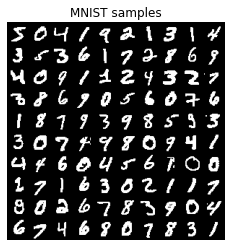

In [0]:
from torchvision import transforms

def load_q3_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    train_data = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    test_data = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)
    return train_data, test_data

def visualize_q3_data():
    train_data, _ = load_q3_data()
    imgs = train_data.data[:100]
    show_samples(imgs.reshape([100, 28, 28, 1]) * 255.0, title=f'MNIST samples')

visualize_q3_data()

In BiGAN, in addition to training a generator $G$ and a discriminator $D$, we train an encoder $E$ that maps from real images $x$ to latent codes $z$. The discriminator now must learn to jointly identify fake $z$, fake $x$, and paired $(x, z)$ that don't belong together. In the original [BiGAN paper](https://arxiv.org/pdf/1605.09782.pdf), they prove that the optimal $E$ learns to invert the generative mapping $G: z \rightarrow x$. Our overall minimax term is now
$$V(D, E, G) = \mathbb{E}_{x \sim p_x}[\mathbb{E}_{z \sim p_E(\cdot | x)}[\log D(x, z)]] + \mathbb{E}_{z \sim p_z}[\mathbb{E}_{x \sim p_G(\cdot | z)}[\log (1 - D(x, z))]]$$

**Architecture**

We will closely follow the MNIST architecture outlined in the original BiGAN paper, Appendix C.1, with one modification: instead of having $z \sim \text{Uniform}[-1, 1]$, we use $z \sim \mathcal N (0, 1)$ with $z \in \mathbb R ^{50}$. 

**Hyperparameters**

We make several modifications to what is listed in the BiGAN paper. We apply $l_2$ weight decay to all weights and decay the step size $\alpha$ linearly to 0 over the course of training. Weights are initialized via the default PyTorch manner. We recommend training for at least 100 epochs -- this part is much less computationally expensive than previous homeworks. 

**Reconstructions**

You should take the first 20 images from the MNIST training set and then display the reconstructions $x_{recon} = G(E(x))$. It's ok if your reconstructions are somewhat lossy; ours are too. We will provide a utility to show these. 

**Testing the representation**

We want to see how good a linear classifier $L$ we can learn such that 
$$y \approx L(E(x))$$
where $y$ is the appropriate label. Fix $E$ and learn a weight matrix $W$ such that your linear classifier is composed of passing $x$ through $E$, then multiplying by $W$, then applying a softmax nonlinearity. Train this via gradient descent with the cross-entropy loss. 

As a baseline, randomly initialize another network $E_{random}$ with the same architecture, fix its weights, and train a linear classifier on top, as done in the previous part.


**You will provide the following deliverables**
1. Plot of the minimax loss term. 
2. 100 samples from the BiGAN
3. A comparison of MNIST images $x$ with their reconstructions $G(E(x))$.
4. Test loss plot for the linear classifier trained on the pretrained encoder, and a randomly initialized encoder. 
5. Final test losses for the two linear classifiers. 

**Feel free to train the networks separately, save the necessary information, and simply use our function to generate the appropriate figures.**


## Solution

In [0]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            # TODO
        )

    def forward(self, x):
        return self.fc(x).reshape(x.shape[0], 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self, z_dim, x_dim):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            # TODO
        )

    def forward(self, z, x):
        x = torch.cat((z, x), dim=1)
        return self.fc(x)

class Encoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Encoder, self).__init__()
        self.fc = nn.Sequential(
            # TODO
        )

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.fc(x)

In [0]:
from torchvision.utils import save_image

class Solver(object):
    def __init__(self, train_data, test_data, n_epochs=100, batch_size=128, latent_dim=50):
        self.log_interval = 100
        self.batch_size = batch_size
        self.train_loader, self.test_loader = self.create_loaders(train_data, test_data)
        self.n_batches_in_epoch = len(self.train_loader)
        self.n_epochs = n_epochs
        self.curr_itr = 0
        self.latent_dim = latent_dim

    def build(self):
        # BiGAN 
        self.d = Discriminator(self.latent_dim, 784).to(device)
        self.e = Encoder(784, self.latent_dim).to(device) 
        self.g = Generator(self.latent_dim, 784).to(device)
        self.g_optimizer = # TODO
        self.g_scheduler = # TODO
        self.d_optimizer = # TODO
        self.d_scheduler = # TODO
        
        # linear classifier 
        self.linear = nn.Linear(self.latent_dim, 10).to(device)
        self.linear_optimizer = torch.optim.Adam(self.linear.parameters(), lr=1e-3)

    def reset_linear(self):
        self.linear = nn.Linear(self.latent_dim, 10).to(device)
        self.linear_optimizer = torch.optim.Adam(self.linear.parameters(), lr=1e-3)

    def create_loaders(self, train_data, test_data):
        train_loader = torch.utils.data.DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_data, batch_size=self.batch_size, shuffle=False)

        return train_loader, test_loader

    def get_discriminator_loss(self, x):
        z_fake = torch.normal(torch.zeros(x.shape[0], self.latent_dim), torch.ones(x.shape[0], self.latent_dim)).to(device)
        z_real = self.e(x).reshape(x.shape[0], self.latent_dim)
        x_fake = self.g(z_fake).reshape(x.shape[0], -1)
        x_real = x.view(x.shape[0], -1)

        d_loss = - 0.5 * (self.d(z_real, x_real)).log().mean() - 0.5 * (1 - self.d(z_fake, x_fake)).log().mean()
        return d_loss


    def train_bigan(self):
        train_losses = []
        val_losses = []
        for epoch_i in tqdm_notebook(range(self.n_epochs), desc='Epoch'):
            epoch_i += 1

            self.d.train()
            self.g.train()
            self.e.train()
            self.batch_loss_history = []

            for batch_i, (x, y) in enumerate(tqdm_notebook(self.train_loader, desc='Batch', leave=False)):
                batch_i += 1
                self.curr_itr += 1
                x = x.to(device).float()

                # discriminator update
                # TODO

                # generator and encoder update
                # TODO

                self.batch_loss_history.append(d_loss.item())

            # step the learning rate
            self.g_scheduler.step()
            self.d_scheduler.step()
            epoch_loss = np.mean(self.batch_loss_history)
            train_losses.append(epoch_loss)
            self.save_samples(100, f'epoch{epoch_i}_samples.png')

        np.save("train_losses.npy", np.array(train_losses))
        self.save_models('weights.pt')
        train_losses = np.array(train_losses)

        return train_losses

    def train_linear_classifier(self):  # (everything already implemented)
        train_losses = []
        val_accs = []
        for epoch_i in tqdm_notebook(range(self.n_epochs // 4), desc='Epoch'):
            epoch_i += 1

            self.e.eval()
            self.linear.train()
            self.batch_loss_history = []

            for batch_i, (x, y) in enumerate(tqdm_notebook(self.train_loader, desc='Batch', leave=False)):
                batch_i += 1
                self.curr_itr += 1
                x = x.to(device).float() # * 2 - 1
                y = y.to(device)

                # calculate loss, take gradient step
                self.linear_optimizer.zero_grad()
                z = self.e(x).detach()
                pred = self.linear(z)
                linear_loss = F.cross_entropy(pred, y)
                linear_loss.backward()
                self.linear_optimizer.step()

                self.batch_loss_history.append(linear_loss.item())

            val_acc = self.val_acc()
            val_accs.append(val_acc)
            epoch_loss = np.mean(self.batch_loss_history)
            train_losses.append(epoch_loss)

        np.save("train_losses.npy", np.array(train_losses))
        self.save_models('weights.pt')
        train_losses = np.array(train_losses)
        val_accs = np.array(val_accs)

        return train_losses, val_accs

    def sample(self, n):
        # TODO

    def save_samples(self, n, filename):
        self.g.eval()
        with torch.no_grad():
            z = (torch.rand(n, self.latent_dim).to(device) - 0.5) * 2
            samples = self.g(z).reshape(-1, 1, 28, 28) * 0.5 + 1
            save_image(samples, filename, nrow=10, normalize=True)

    def val_acc(self):
        self.e.eval()
        self.linear.eval()

        val_acc_total = 0
        val_items = 0
        with torch.no_grad():
            for (inputs, labels) in self.test_loader:
                inputs = inputs.to(device).float()
                z = self.e(inputs)
                labels = labels.to(device)
                logits = self.linear(z)
                predictions = torch.argmax(logits, dim=1)
                num_correct = torch.sum(predictions == labels).float()
                val_acc_total += num_correct
                val_items += inputs.shape[0]

        return (val_acc_total / val_items).detach().cpu().numpy()

    def save_models(self, filename):
        torch.save(self.g.state_dict(), "g_" + filename)
        torch.save(self.d.state_dict(), "d_" + filename)
        torch.save(self.e.state_dict(), "e_" + filename)

    def load_models(self, filename):
        self.g.load_state_dict(torch.load("g_" + filename))
        self.d.load_state_dict(torch.load("d_" + filename))
        self.e.load_state_dict(torch.load("e_" + filename))

In [0]:
def q3(train_data, test_data):
    """
    train_data: A PyTorch dataset that contains (n_train, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST
    test_data: A PyTorch dataset that contains (n_test, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST

    Returns
    - a (# of training iterations,) numpy array of BiGAN minimax losses evaluated every minibatch
    - a (100, 28, 28, 1) numpy array of BiGAN samples that lie in [0, 1]
    - a (40, 28, 28, 1) numpy array of 20 real image / reconstruction pairs
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on the BiGAN encoder evaluated every epoch 
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on a random encoder evaluated every epoch 
    """

    solver = Solver(train_data, test_data, n_epochs=100)
    solver.build()

    # get random encoder accuracy
    print("Training linear classifier on random encoder")
    train_losses, val_accs = solver.train_linear_classifier()

    # train bigan
    print("Training BiGAN")
    bigan_losses = solver.train_bigan()
    samples = # TODO
    train_images = # TODO
    recons = # TODO reconstructions(train_images)

    # see benefit of unsupervised learning
    solver.reset_linear()
    print("Training linear classifier on BiGAN encoder")
    bigan_train_losses, bigan_val_accs = solver.train_linear_classifier()

    print(f"Final BiGAN test linear accuracy: {bigan_val_accs[-1]}")
    print(f"Final random encoder test linear accuracy: {val_accs[-1]}")

    return bigan_losses, samples, np.concatenate([train_images, recons], axis=0).transpose(0, 2, 3, 1), bigan_train_losses, train_losses

## Results

In [0]:
def plot_q3_supervised(pretrained_losses, random_losses, title, fname):
    plt.figure()
    xs = np.arange(len(pretrained_losses))
    plt.plot(xs, pretrained_losses, label='bigan')
    xs = np.arange(len(random_losses))
    plt.plot(xs, random_losses, label='random init')
    plt.legend()
    plt.title(title)
    # savefig(fname)

def q3_save_results(fn):
    train_data, test_data = load_q3_data()
    gan_losses, samples, reconstructions, pretrained_losses, random_losses = fn(train_data, test_data)

    plot_gan_training(gan_losses, 'Q3 Losses', 'results/q3_gan_losses.png')
    plot_q3_supervised(pretrained_losses, random_losses, 'Linear classification losses', 'results/q3_supervised_losses.png')
    show_samples(samples * 255.0, fname=None, title='BiGAN generated samples')
    show_samples(reconstructions * 255.0, nrow=20, fname=None, title=f'BiGAN reconstructions')
    print('BiGAN final linear classification loss:', pretrained_losses[-1])
    print('Random encoder linear classification loss:', random_losses[-1])

q3_save_results(q3)

# Question 4: CycleGAN
In this question, you'll train a CycleGAN model to learn to translate between two different image domains, without any paired data. Execute the following cell to visualize our two datasets: MNIST and Colored MNIST. 

In [0]:
!wget https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png -O lena.jpg

--2020-05-12 12:03:16--  https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473831 (463K) [image/png]
Saving to: ‘lena.jpg’

lena.jpg            100%[===================>] 462.73K  1.95MB/s    in 0.2s    

2020-05-12 12:03:16 (1.95 MB/s) - ‘lena.jpg’ saved [473831/473831]



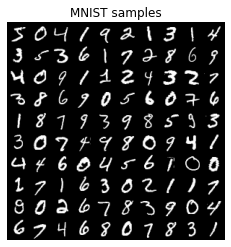

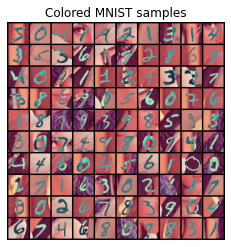

In [0]:
import PIL
import cv2
import scipy

def get_colored_mnist(data):
    # from https://www.wouterbulten.nl/blog/tech/getting-started-with-gans-2-colorful-mnist/
    # Read Lena image
    lena = PIL.Image.open('./lena.jpg')

    # Resize
    batch_resized = np.asarray([scipy.ndimage.zoom(image, (2.3, 2.3, 1), order=1) for image in data])

    # Extend to RGB
    batch_rgb = np.concatenate([batch_resized, batch_resized, batch_resized], axis=3)

    # Make binary
    batch_binary = (batch_rgb > 0.5)

    batch = np.zeros((data.shape[0], 28, 28, 3))

    for i in range(data.shape[0]):
        # Take a random crop of the Lena image (background)
        x_c = np.random.randint(0, lena.size[0] - 64)
        y_c = np.random.randint(0, lena.size[1] - 64)
        image = lena.crop((x_c, y_c, x_c + 64, y_c + 64))
        image = np.asarray(image) / 255.0

        # Invert the colors at the location of the number
        image[batch_binary[i]] = 1 - image[batch_binary[i]]

        batch[i] = cv2.resize(image, (0, 0), fx=28 / 64, fy=28 / 64, interpolation=cv2.INTER_AREA)
    return batch.transpose(0, 3, 1, 2)

def load_q4_data():
    train, _ = load_q3_data()
    mnist = np.array(train.data.reshape(-1, 28, 28, 1) / 255.0)
    colored_mnist = get_colored_mnist(mnist)
    return mnist.transpose(0, 3, 1, 2), colored_mnist

def visualize_cyclegan_datasets():
    mnist, colored_mnist = load_q4_data()
    mnist, colored_mnist = mnist[:100], colored_mnist[:100]
    show_samples(mnist.reshape([100, 28, 28, 1]) * 255.0, title=f'MNIST samples')
    show_samples(colored_mnist.transpose([0, 2, 3, 1]) * 255.0, title=f'Colored MNIST samples')

visualize_cyclegan_datasets()

In [CycleGAN](https://arxiv.org/pdf/1703.10593.pdf), the goal is to learn functions $F$ and $G$ that can transform images from $X \rightarrow Y$ and vice-versa. This is an unconstrained problem, so we additionally enforce the *cycle-consistency* property, where we want 
$$x \approx G(F(x))$$
and  
$$y \approx F(G(x))$$
This loss function encourages $F$ and $G$ to approximately invert each other. In addition to this cycle-consistency loss, we also have a standard GAN loss such that $F(x)$ and $G(y)$ look like real images from the other domain. 

Since this is a bonus question, we won't do much hand-holding. We recommend reading through the original paper to get a sense of what architectures and hyperparameters are useful. Note that our datasets are fairly simple, so you won't need excessively large models. 

**You will report the following deliverables**
1. A set of images showing real MNIST digits, transformations of those images into Colored MNIST digits, and reconstructions back into the greyscale domain. 
2. A set of images showing real Colored MNIST digits, transformations of those images, and reconstructions. 

## Solution

In [0]:
def q4(mnist_data, cmnist_data):
    """
    mnist_data: An (60000, 1, 28, 28) numpy array of black and white images with values in [0, 1]
    cmnist_data: An (60000, 3, 28, 28) numpy array of colored images with values in [0, 1]

    Returns
    - a (20, 28, 28, 1) numpy array of real MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of translated Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of reconstructed MNIST digits, in [0, 1]

    - a (20, 28, 28, 3) numpy array of real Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of translated MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of reconstructed Colored MNIST digits, in [0, 1]
    """
    """ YOUR CODE HERE """

## Results

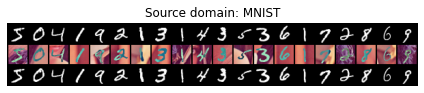

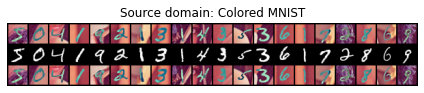

In [0]:
def q4_save_results(fn):
    mnist, cmnist = load_q4_data()

    m1, c1, m2, c2, m3, c3 = fn(mnist, cmnist)
    m1, m2, m3 = m1.repeat(3, axis=3), m2.repeat(3, axis=3), m3.repeat(3, axis=3)
    mnist_reconstructions = np.concatenate([m1, c1, m2], axis=0)
    colored_mnist_reconstructions = np.concatenate([c2, m3, c3], axis=0)

    show_samples(mnist_reconstructions * 255.0, nrow=20,
                 fname=None,
                 title=f'Source domain: MNIST')
    show_samples(colored_mnist_reconstructions * 255.0, nrow=20,
                 fname=None,
                 title=f'Source domain: Colored MNIST')
    pass

q4_save_results(q4)